In [1]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import scipy.sparse as sp

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib

font = {"family": "sans-serif", "weight": "bold", "size": 13}

from abc import ABC

## Interpolation/Prolongation in 1D

In [2]:
# to be implemented
class Restriction(ABC):
    @staticmethod
    def restrict(x):
        pass

    @staticmethod
    def matrix(x):
        pass


# to be implemented
class Prolongation(ABC):
    @staticmethod
    def prolong(x):
        pass

    @staticmethod
    def matrix(x):
        pass

In [3]:
class FemProlongation(Prolongation):
    @staticmethod
    def prolong(x):
        return FemProlongation.matrix(x).dot(x)

    @staticmethod
    def matrix(x):
        l = len(x)
        data = np.tile((0.5, 1, 0.5), l)
        rows = (
            np.array([0, 1, 2])[None] + np.array([2])[None] * np.arange(l)[:, None]
        ).flatten()
        cols = (
            np.array([0, 0, 0])[None] + np.array([1])[None] * np.arange(l)[:, None]
        ).flatten()
        return sp.coo_matrix((data, (rows, cols))).tocsr()


class WeightedRestriction(Restriction):
    @staticmethod
    def restrict(x):
        return WeightedRestriction.matrix(x).dot(x)

    @staticmethod
    def matrix(x):
        l = len(x) // 2
        data = np.tile((0.25, 0.5, 0.25), l)
        cols = (
            np.array([0, 1, 2])[None] + np.array([2])[None] * np.arange(l)[:, None]
        ).flatten()
        rows = (
            np.array([0, 0, 0])[None] + np.array([1])[None] * np.arange(l)[:, None]
        ).flatten()
        return sp.coo_matrix((data, (rows, cols))).tocsr()

In [4]:
def jacobi(A, b, x):
    r = b - A.dot(x)
    return x + sp.diags(1 / A.diagonal()).dot(r)


def gauss_seidel(A, b, x):
    x_old = np.array(x)
    for i in range(A.shape[0]):
        x[i] = b[i] - A[i, :i].dot(x[:i]) - A[i, (i + 1) :].dot(x_old[(i + 1) :])
    return x / A.diagonal()


def conjugate_gradient(A, b, x):
    return sp.linalg.cg(A, b, x0=x, maxiter=1)[0]

In [5]:
def multigrid(
    Ah, fh, smoother_info, hm_threshold, restriction, prolongation, hm=0, gamma=1
):
    """
    v1: pre-smoothing
    v2: post-smoothing
    smoother: (A, f, vh) -> vh'
    """
    smoother, v1, v2 = smoother_info

    vh = np.zeros_like(fh)
    for _ in range(v1):
        vh = smoother(Ah, fh, vh)

    if hm == hm_threshold:
        vh = np.linalg.solve(Ah, fh)
    else:
        f2h = restriction.restrict(fh - Ah.dot(vh))
        restricted_vh = restriction.restrict(vh)
        v2h = np.zeros_like(restricted_vh)

        pvh = prolongation.matrix(restricted_vh)
        rvh = restriction.matrix(vh)
        A2h = rvh.dot(Ah.dot(pvh.toarray()))
        for _ in range(gamma):
            v2h = multigrid(
                A2h,
                f2h,
                smoother_info,
                hm_threshold,
                restriction,
                prolongation,
                hm=hm + 1,
                gamma=gamma,
            )
        vh += prolongation.prolong(v2h)

    for _ in range(v2):
        vh = smoother(Ah, fh, vh)

    return vh

## 1D Model problem

In [6]:
def homo_diffusion_problem(N, rhs_f, a=0, b=1):
    omega = np.linspace(a, b, N)
    h = omega[1] - omega[0]
    inverse_squared_h = 1 / (h**2)

    rhs = rhs_f(omega)

    A = (
        np.diag(np.full(N - 1, -inverse_squared_h), -1)
        + np.diag(np.full(N - 1, -inverse_squared_h), 1)
        + np.diag(np.full(N, 2 * inverse_squared_h))
    )
    A[[0, -1]] = 0
    A[0, 0] = A[-1, -1] = 1
    rhs[[0, -1]] = 0

    return omega, A, rhs

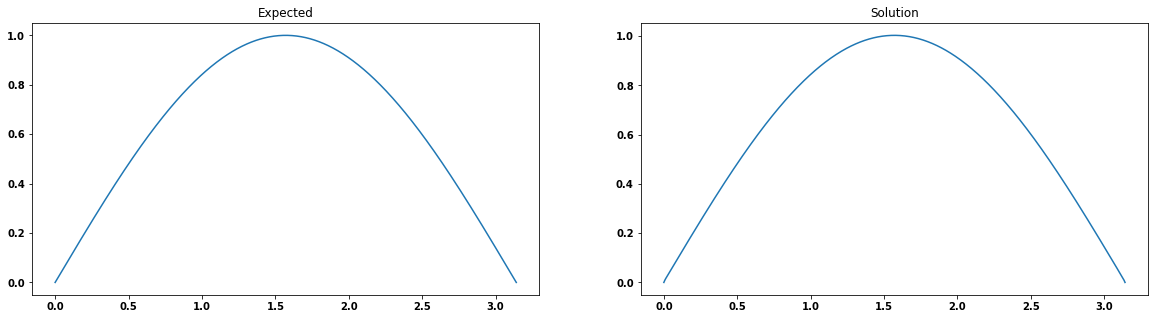

In [7]:
omega, A, rhs = homo_diffusion_problem(1023, np.sin, b=np.pi)
out = multigrid(A, rhs, (jacobi, 3, 3), 3, WeightedRestriction, FemProlongation)

plt.rc("font", **font)
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.title("Expected")
plt.plot(omega, rhs)

plt.subplot(1, 2, 2)
plt.title("Solution")
plt.plot(omega, out);

## Multigrid in 2D

In [8]:
class Prolongation2D(Prolongation):
    @staticmethod
    def prolong(x):
        return Prolongation2D.matrix(x).dot(x[0])

    @staticmethod
    def matrix(x):
        u, nx, ny = x
        return sp.kron(
            FemProlongation.matrix(np.empty(ny)), FemProlongation.matrix(np.empty(nx))
        ).tocsr()


class WeightedRestriction2D(Restriction):
    @staticmethod
    def restrict(x):
        return WeightedRestriction2D.matrix(x).dot(x[0])

    @staticmethod
    def matrix(x):
        u, nx, ny = x
        return sp.kron(
            WeightedRestriction.matrix(np.empty(ny)),
            WeightedRestriction.matrix(np.empty(nx)),
        ).tocsr()


class InjectionRestriction2D(Restriction):
    @staticmethod
    def restrict(x):
        return InjectionRestriction2D.matrix(x).dot(x[0])

    @staticmethod
    def matrix(x):
        u, nx, ny = x
        nxp, nyp = (nx + 1) // 2 - 1, (ny + 1) // 2 - 1
        data = np.ones(nxp * nyp)
        rows = np.arange(nxp * nyp)
        cols = (
            np.linspace(0, nx, nxp, dtype=int, endpoint=False)[None]
            + np.linspace(0, ny - 1, nyp, dtype=int)[:, None] * nx
        ).flatten()
        return sp.coo_matrix((data, (rows, cols)), shape=(nxp * nyp, nx * ny))

In [9]:
def multigrid_2d(
    Ah, fh, smoother_info, hm_threshold, n, restriction, prolongation, hm=0, gamma=1
):
    """
    v1: pre-smoothing
    v2: post-smoothing
    smoother: (A, f, vh) -> vh'
    """
    smoother, v1, v2 = smoother_info
    nx, ny = n

    vh = np.zeros_like(fh)
    for _ in range(v1):
        vh = smoother(Ah, fh, vh)

    if hm == hm_threshold:
        vh = sp.linalg.spsolve(Ah, fh)
    else:
        nxp = (nx + 1) // 2 - 1
        nyp = (ny + 1) // 2 - 1

        rh = fh - Ah.dot(vh)
        rmatrix = restriction.matrix((rh, nx, ny))
        f2h = rmatrix.dot(rh)

        pmatrix = prolongation.matrix((f2h, nxp, nyp))
        A2h = rmatrix.dot((pmatrix.transpose().dot(Ah.T)).transpose())
        for _ in range(gamma):
            v2h = multigrid_2d(
                A2h,
                f2h,
                smoother_info,
                hm_threshold,
                (nxp, nyp),
                restriction,
                prolongation,
                hm=hm + 1,
                gamma=gamma,
            )
            vh += pmatrix.dot(v2h)

    for _ in range(v2):
        vh = smoother(Ah, fh, vh)

    return vh

## 2D Model problem

In [10]:
def homo_diffusion_problem_2d(omega, N, rhs_f):
    Nx, Ny = N

    x = np.linspace(*omega[0], Nx)
    y = np.linspace(*omega[1], Ny)

    hx = x[1] - x[0]
    hy = y[1] - y[0]

    X, Y = np.meshgrid(x, y)

    inverse_squared_Nx = 1 / (hx**2)
    inverse_squared_Ny = 1 / (hy**2)

    rhs = rhs_f(X.flatten(), Y.flatten())

    data = (
        -inverse_squared_Ny * np.ones((Ny - 1) * Nx),
        -inverse_squared_Nx * np.ones(Nx * Ny - 1),
        2 * (inverse_squared_Nx + inverse_squared_Ny) * np.ones(Nx * Ny),
        -inverse_squared_Nx * np.ones(Nx * Ny - 1),
        -inverse_squared_Ny * np.ones((Nx - 1) * Ny),
    )
    A = sp.diags(data, (-Nx, -1, 0, 1, Ny), shape=(Nx * Ny, Nx * Ny), format="lil")

    # y boundary
    for i in range(Nx):
        A[i, A[i].nonzero()] = 0
        # U_{1,1}, U_{2,1}, ...
        A[i, i] = 1
        rhs[i] = 0
    for i in range(A.shape[0] - Nx, A.shape[0]):
        A[i, A[i].nonzero()] = 0
        # U_{1,Ny-1}, U_{1,Ny-1}, ...
        A[i, i] = 1
        rhs[i] = 0

    # x boundary (left/right)
    for i in range(1, Ny):
        j = i * Nx
        A[j, A[j].nonzero()] = 0
        # U_{1,2}, U_{1,3}, ...
        A[j, j] = 1
        rhs[j] = 0
    for i in range(1, Ny):
        j = i * Nx + Nx - 1
        A[j, A[j].nonzero()] = 0
        # U_{Nx-1,2}, U_{Nx-1,3}, ...
        A[j, j] = 1
        rhs[j] = 0

    return (X, Y), A.tocsr(), rhs

## Check operators $I_{2h}^h/I_{h}^{2h}$

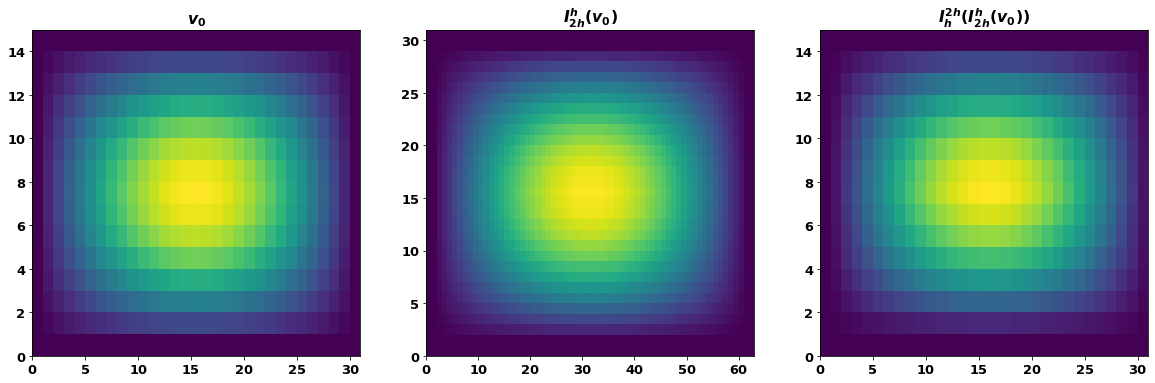

In [11]:
omega = np.zeros((2, 2))
omega[[0, 1], 1] = np.pi
nx, ny = (31, 15)


def f(x, y):
    return 2 * np.sin(x) * np.sin(y)


(X, Y), A, rhs = homo_diffusion_problem_2d(omega, (nx, ny), f)
F = f(X.flatten(), Y.flatten())

plt.rc("font", **font)
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.pcolormesh(F.reshape(ny, nx))
plt.title("$v_0$")

plt.subplot(1, 3, 2)
u = Prolongation2D.prolong((F, nx, ny))
plt.pcolormesh(u.reshape((ny + 1) * 2 - 1, (nx + 1) * 2 - 1))
plt.title("$I_{2h}^h(v_0)$")

plt.subplot(1, 3, 3)
plt.pcolormesh(
    InjectionRestriction2D.restrict((u, (nx + 1) * 2 - 1, (ny + 1) * 2 - 1)).reshape(
        ny, nx
    )
)
plt.title("$I_h^{2h}(I_{2h}^h(v_0))$");

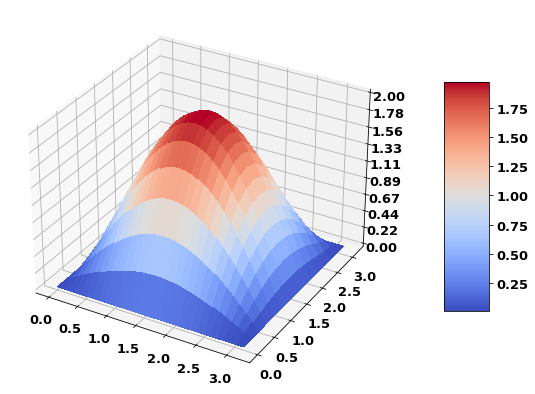

In [12]:
def plot_3d(X, Y, Z):
    plt.rc("font", **font)
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20, 7))
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter("{x:.02f}")

    fig.colorbar(surf, shrink=0.6, aspect=5)
    plt.show()


plot_3d(X, Y, f(X, Y))

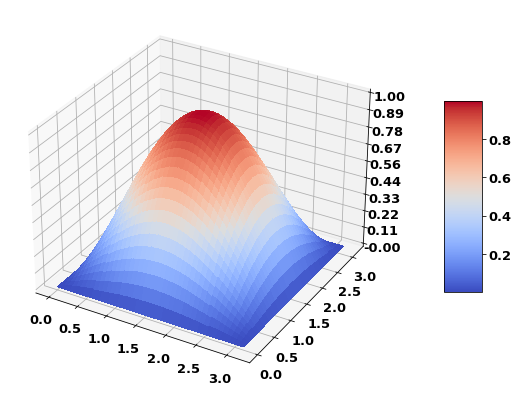

In [13]:
omega = np.zeros((2, 2))
omega[[0, 1], 1] = np.pi
nx, ny = (127, 127)

(X, Y), A, rhs = homo_diffusion_problem_2d(omega, (nx, ny), f)
out = multigrid_2d(
    A,
    rhs,
    (conjugate_gradient, 3, 3),
    3,
    (nx, ny),
    WeightedRestriction2D,
    Prolongation2D,
)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20, 7))
surf = ax.plot_surface(
    X, Y, out.reshape(ny, nx), cmap=cm.coolwarm, linewidth=0, antialiased=False
)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter("{x:.02f}")

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show();

In [14]:
%time sp.linalg.spsolve(A, rhs)
%time _ = multigrid_2d(A, rhs, (conjugate_gradient, 1, 1), 3, (nx, ny), WeightedRestriction2D, Prolongation2D)

CPU times: user 186 ms, sys: 35.1 ms, total: 221 ms
Wall time: 198 ms
CPU times: user 60.4 ms, sys: 16.7 ms, total: 77.1 ms
Wall time: 43.5 ms
